In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser as parser
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import hvplot.pandas
from holoviews import opts, dim
from geopandas import GeoDataFrame, read_file
from os.path import exists
from urllib.request import urlretrieve

In [7]:
# Read csv file as a dataframe
raw_ship_data = pd.read_csv('data.csv')
print(f"Finished reading {len(raw_ship_data)} lines of data")

Finished reading 1003 lines of data


In [8]:
raw_ship_data.head()

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,Dimension A,Dimension B,Dimension C,Dimension D,MaximumStaticDraught,MessageID
0,2023-12-09 08:05:51.944186364 +0000 UTC,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,28,107,15,15,4.5,5
1,2023-12-09 08:05:54.203014122 +0000 UTC,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,7,21,2,7,2.4,5
2,2023-12-09 08:05:57.546130448 +0000 UTC,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,138,20,20,4,10.0,5
3,2023-12-09 08:06:05.451479994 +0000 UTC,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,18,32,5,5,2.4,5
4,2023-12-09 08:06:08.806450979 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,21,154,24,6,0.0,5


In [9]:
# Print the columns of our data
print(raw_ship_data.columns)

Index(['time_utc', 'CallSign', 'ShipName', 'Type', 'ImoNumber', 'MMSI',
       'latitude', 'longitude', 'Destination', 'FixType', 'Dimension A',
       'Dimension B', 'Dimension C', 'Dimension D', 'MaximumStaticDraught',
       'MessageID'],
      dtype='object')


Με μία επισκόπηση του επιστρεφόμενου πίνακα, παρατηρούμε πως θα χρειαστεί να προχωρήσουμε σε ορισμένες αλλαγές προκειμένου να διευκολυνθούμε στη μετέπειτα επεξεργασία. Πιο συγκεκριμένα θα διαμορφώσουμε τα στοιχεία χρόνου, συντεταγμένων και διαστάσεων.

In [15]:
# Coordinates format to point format for plotting and visualization
geo_raw_ship_data = gpd.GeoDataFrame(raw_ship_data, geometry=gpd.points_from_xy(raw_ship_data.longitude, raw_ship_data.latitude), crs="EPSG:4326")
geo_raw_ship_data.head()

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,Dimension A,Dimension B,Dimension C,Dimension D,MaximumStaticDraught,MessageID,geometry
0,2023-12-09 08:05:51.944186364 +0000 UTC,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,28,107,15,15,4.5,5,POINT (33.05835 34.66968)
1,2023-12-09 08:05:54.203014122 +0000 UTC,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,7,21,2,7,2.4,5,POINT (33.00969 34.64540)
2,2023-12-09 08:05:57.546130448 +0000 UTC,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,138,20,20,4,10.0,5,POINT (29.00512 35.82620)
3,2023-12-09 08:06:05.451479994 +0000 UTC,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,18,32,5,5,2.4,5,POINT (33.00900 34.64513)
4,2023-12-09 08:06:08.806450979 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,21,154,24,6,0.0,5,POINT (33.01678 34.65245)


In [10]:
# Get the shape of our dataframe
raw_ship_data.shape

(1003, 16)

In [52]:
# Get the length of dataframe
len(raw_ship_data)

1003

(NaN ή null τιμές) στο DataFrame raw_ship_data
df.isnull(),  'NaN' τμές θα απαντήσει σε True or False.
True αν βρεί τέτοιες τιμές και False αντίστοιχα 

df.isnull().any().any()- Το πρώτο .any() ελέγχει εάν υπάρχει τουλάχιστον μία τιμή True κατά μήκος κάθε στήλης και το δεύτερο .any() ελέγχει εάν υπάρχει τουλάχιστον μία τιμή True σε όλες τις στήλες δινει True αν λειπουν τιμες και False αν δεν λειπουν

In [53]:
# Print missing values
print("Any missing values:", raw_ship_data.isnull().any().any())

# Count missing values
null_counts_total = raw_ship_data.isnull().sum().sum()
print("null_counts_total:", null_counts_total)

Any missing values: True
null_counts_total: 81


In [54]:
#  Print dataframe null values in each column
null_counts = raw_ship_data.isnull().sum()
print("Null counts in each column:") 
print(null_counts)

Null counts in each column:
CallSign                17
ShipName                 0
Type                     0
ImoNumber                0
MMSI                     0
latitude                 0
longitude                0
Destination             64
FixType                  0
Dimension A              0
Dimension B              0
Dimension C              0
Dimension D              0
MaximumStaticDraught     0
MessageID                0
dtype: int64


In [11]:
# Rows with at least one null value:
raw_ship_data[raw_ship_data.isnull().any(axis=1)]

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,Dimension A,Dimension B,Dimension C,Dimension D,MaximumStaticDraught,MessageID
4,2023-12-09 08:06:08.806450979 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,21,154,24,6,0.0,5
20,2023-12-09 08:07:43.529290641 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831317,34.639927,NaN,0,0,236,0,32,0.0,5
32,2023-12-09 08:08:52.471973589 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831242,34.639950,NaN,1,191,45,22,10,0.0,5
68,2023-12-09 08:12:54.22487949 +0000 UTC,P3CQ9,PETSAS I,0,0,209352000,34.664468,33.029690,NaN,15,0,0,0,0,0.0,5
77,2023-12-09 08:13:34.066695382 +0000 UTC,EAPC,EAPC CONTROL,0,0,428990000,31.642125,34.531130,NaN,1,0,0,0,0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,2023-12-09 09:33:59.397178623 +0000 UTC,XCAN5,ADMIRAL,31,0,345050010,34.673365,33.066440,NaN,0,8,30,6,4,0.0,5
958,2023-12-09 09:36:10.766430451 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652465,33.016780,NaN,1,21,154,24,6,0.0,5
967,2023-12-09 09:36:44.471522672 +0000 UTC,XCAN5,ADMIRAL,31,9421582,345050010,34.673347,33.066408,NaN,1,8,30,6,4,0.0,5
976,2023-12-09 09:37:31.104895846 +0000 UTC,EAPC,EAPC CONTROL,0,0,428990000,31.642107,34.531045,NaN,1,0,0,0,0,0.0,5


In [12]:
# Def null values 
def rows_with_null_values(dataframe, column_name = None):
    if column_name is None:
        return dataframe[dataframe.isnull().any(axis = 1)]
    else:
        return dataframe[dataframe[column_name].isnull()]

In [13]:
rows_with_null_values(raw_ship_data, column_name = "CallSign")

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,Dimension A,Dimension B,Dimension C,Dimension D,MaximumStaticDraught,MessageID
20,2023-12-09 08:07:43.529290641 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831317,34.639927,NaN,0,0,236,0,32,0.0,5
32,2023-12-09 08:08:52.471973589 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831242,34.639950,NaN,1,191,45,22,10,0.0,5
93,2023-12-09 08:14:51.427148033 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831232,34.639995,NaN,1,191,45,22,10,0.0,5
150,2023-12-09 08:20:51.080426955 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831103,34.640052,NaN,1,191,45,22,10,0.0,5
210,2023-12-09 08:26:51.933645457 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831085,34.640077,NaN,1,191,45,22,10,0.0,5
269,2023-12-09 08:32:58.220652051 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831223,34.639997,NaN,1,191,45,22,10,0.0,5
328,2023-12-09 08:38:57.410927269 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831207,34.640012,NaN,1,191,45,22,10,0.0,5
391,2023-12-09 08:44:53.199424716 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831207,34.640012,NaN,1,191,45,22,10,0.0,5
460,2023-12-09 08:50:55.616028787 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831207,34.640012,NaN,1,191,45,22,10,0.0,5
524,2023-12-09 08:56:59.340063451 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831207,34.640012,NaN,1,191,45,22,10,0.0,5


In [14]:
# Print number of unique call signs
print("Number of unique call signs:", raw_ship_data["CallSign"].nunique())

Number of unique call signs: 91


In [59]:
# Dataframe unique values overview
raw_ship_data.nunique()

CallSign                 91
ShipName                 91
Type                     24
ImoNumber                76
MMSI                     92
latitude                752
longitude               742
Destination              44
FixType                   5
Dimension A              59
Dimension B              42
Dimension C              23
Dimension D              22
MaximumStaticDraught     49
MessageID                 1
dtype: int64

In [60]:
raw_ship_data['length'] = (raw_ship_data['Dimension A'] + raw_ship_data['Dimension B'])
raw_ship_data['width'] = (raw_ship_data['Dimension C'] + raw_ship_data['Dimension D'])
raw_ship_data = raw_ship_data.drop(columns=['Dimension A', 'Dimension B', 'Dimension C', 'Dimension D'])

In [61]:
length_dimension = raw_ship_data[(raw_ship_data['length']==0)]
width_dimension = raw_ship_data[(raw_ship_data['width']==0)]
print(length_dimension['Type'].unique())
print(width_dimension['Type'].unique())

[70 52  0]
[70 52  0]


70 = cargo,
52 = Tug,
0 = default,

In [62]:
# Get all the ships that are of type cargo, tug, default
cargo = raw_ship_data[(raw_ship_data['Type'] == 70)]
tug = raw_ship_data[(raw_ship_data['Type'] == 52)]
default = raw_ship_data[(raw_ship_data['Type'] == 0)]

In [63]:
# Calculate the mean value of their dimensions
cargo_mean_length = int(cargo['length'].mean())
cargo_mean_width = int(cargo['width'].mean())

tug_mean_length = int(tug['length'].mean())
tug_mean_width = int(tug['width'].mean())

default_mean_length = int(default['length'].mean())
default_mean_width = int(default['width'].mean())

In [64]:
# Replace the zero values with the mean value
raw_ship_data.loc[(raw_ship_data['length'] == 0) & (raw_ship_data['Type']==70), ['length']] = cargo_mean_length
raw_ship_data.loc[(raw_ship_data['width'] == 0) & (raw_ship_data['Type']==70), ['width']] = cargo_mean_width

raw_ship_data.loc[(raw_ship_data['length'] == 0) & (raw_ship_data['Type']==52), ['length']] = tug_mean_length
raw_ship_data.loc[(raw_ship_data['width'] == 0) & (raw_ship_data['Type']==52), ['width']] = tug_mean_width

raw_ship_data.loc[(raw_ship_data['length'] == 0) & (raw_ship_data['Type']==0), ['length']] = default_mean_length
raw_ship_data.loc[(raw_ship_data['length'] == 0) & (raw_ship_data['Type']==0), ['width']] = tug_mean_width

In [65]:
#raw_ship_data.loc[(raw_ship_data['width'] == 0) & (raw_ship_data['Type']==70)]
raw_ship_data = raw_ship_data
display(raw_ship_data)

,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,MaximumStaticDraught,MessageID,length,width
time_utc,,,,,,,,,,,,,
2023-12-09 08:05:51.944186364 +0000 UTC,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,4.5,5,135,30
2023-12-09 08:05:54.203014122 +0000 UTC,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,2.4,5,28,9
2023-12-09 08:05:57.546130448 +0000 UTC,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,10.0,5,158,24
2023-12-09 08:06:05.451479994 +0000 UTC,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,2.4,5,50,10
2023-12-09 08:06:08.806450979 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,0.0,5,175,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-09 09:39:23.429106768 +0000 UTC,V3OJ,HOLMA,33,7333327,312349000,34.645230,33.010070,HERZLIYA MARINA,1,3.0,5,40,9
2023-12-09 09:39:29.631362384 +0000 UTC,SVSV7,CHRISTOS LV,52,9371464,241776000,34.668703,33.052005,CYLMS,1,4.6,5,56,16
2023-12-09 09:39:29.747263668 +0000 UTC,6BBI,EGY CROWN,79,9216107,622113180,34.666713,33.078463,CYLMS ANCHORAGE AREA,0,9.5,5,140,50


In [66]:
# Find the number of unique ships inside of our table using as key the MMSI since it has no 0 values and it is an ID attribute
print(np.sort(raw_ship_data['MMSI'].unique()))

[  4282000 209005000 209166000 209343000 209352000 209492000 209511000
 209969000 210282000 210330000 210588000 210595000 211920000 212212000
 212230000 212319000 212541000 212717000 212858000 212872000 215013000
 215209000 229447000 233303000 235090927 236723000 241776000 244810178
 247274900 248823000 255806109 255977000 255979000 256060000 256081000
 256251000 257073920 271044343 271047045 271051041 271052043 305299000
 305384000 311000706 312349000 319222400 319234300 319287000 345050010
 352002159 352002364 352002749 353822000 371343000 375369000 428000112
 428000407 428007000 428009070 428045000 428066000 428068000 428990000
 470763000 511100389 511100460 511100504 511100835 518998397 538002973
 538003685 538007432 538009102 538009176 563112000 572705210 577171000
 613226010 613871403 622113180 630001049 636014902 636015074 636019201
 636021330 636021691 636022888 667001448 667001603 668116210 671290100
 987170323]


In [67]:
# Get a dataframe with only the single ships
unique_ships = raw_ship_data.drop_duplicates(subset=['MMSI'])
display(unique_ships)

,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,MaximumStaticDraught,MessageID,length,width
time_utc,,,,,,,,,,,,,
2023-12-09 08:05:51.944186364 +0000 UTC,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,4.5,5,135,30
2023-12-09 08:05:54.203014122 +0000 UTC,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,2.4,5,28,9
2023-12-09 08:05:57.546130448 +0000 UTC,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,10.0,5,158,24
2023-12-09 08:06:05.451479994 +0000 UTC,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,2.4,5,50,10
2023-12-09 08:06:08.806450979 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,0.0,5,175,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-09 09:09:12.122336029 +0000 UTC,V7SN2,DANCHOR IX,99,9316787,538003685,32.814877,35.030665,NaN,1,2.1,5,59,9
2023-12-09 09:09:29.41629581 +0000 UTC,3E3832,NOVA CORALIA,70,8918409,352002159,32.818160,35.016760,IL HFA,1,7.1,5,119,18
2023-12-09 09:09:38.548450027 +0000 UTC,5BWY5,LEDRA EXPLORER,52,0,210330000,34.541397,33.239995,LIMASSOL CYPRUS,0,3.0,5,39,9


In [68]:
# Find the different type of ships
ship_type = unique_ships['Type'].unique()
print(np.sort(ship_type))

[ 0 31 33 34 35 37 40 50 51 52 59 60 68 69 70 71 79 80 82 89 90 91 92 99]


 0  = default,
 31 = Towing,
 33 = Dredging,
 34 = Diving,
 35 = Military,
 37 = Pleasure,
 40 = HighSpeedCraft (HSC),
 50 = Pilot,
 51 = SAR,
 52 = Tug,
 59 = Noncombatant,
 60 = Passenger,
 68 = Passenger Reserved for future use,
 69 = Passenger No additional information,
 70 = Cargo all ships of this type,
 71 = Cargo Hazardous category A,
 79 = Cargo No additional information,
 80 = Tanker all ships of this type,
 82 = Tanker Hazardous category B,
 89 = Tanker No additional information,
 90 = Other Type all ships of this type,
 91 = Other Type Hazardous category A,
 92 = Other Type Hazardous category B,
 99 = Other Type no additional information

In [69]:
unique_ships.loc[(unique_ships['Type'] == 71) | (unique_ships['Type'] == 79)] = 70
unique_ships.loc[(unique_ships['Type'] == 68) | (unique_ships['Type'] == 69)] = 60
unique_ships.loc[(unique_ships['Type'] == 82) | (unique_ships['Type'] == 89)] = 80
unique_ships.loc[(unique_ships['Type'] == 91) | (unique_ships['Type'] == 92) | (unique_ships['Type'] == 99)] = 90


In [70]:
proportion = unique_ships['Type'].value_counts(normalize=True)

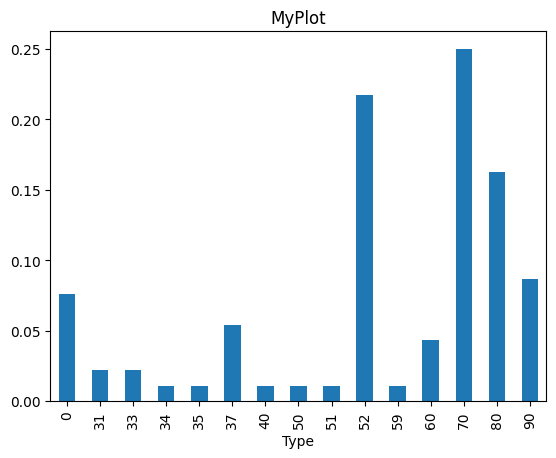

In [71]:
plot = proportion.sort_index().plot(kind='bar', title='MyPlot')

In [72]:
# Find the different fix types provided
fix_type = raw_ship_data['FixType'].unique()
print(fix_type)

[ 1  0 15  6  3]


0 = Default
1 = GPS
3 = GPS + GLONASS
6 = INS
15 = internal GNSS


In [73]:
#unique_ships = raw_ship_data[(raw_ship_data['MMSI'].unique())]
#print(unique_ships)

-International Maritime Organization (IMO) SHIP IDENTIFICATION NUMBER 
Αποτελεί μοναδικό κωδικό που ανατίθεται σε κάθε πλοίο. Αυτός ο αριθμός χρησιμοποιείται για την ταυτοποίηση και το παρακολούθηση των πλοίων σε διεθνές επίπεδο.


Είτε πρόκειται για ένα μεγάλο φορτηγό πλοίο, ένα πλοίο επιβατών, ένα δεξαμενόπλοιο, 
είτε για ένα μικρότερο σκάφος, η ύπαρξη ενός μοναδικού αναγνωριστικού αριθμού συμβάλλει 
στην παρακολούθηση και διαχείριση των θαλάσσιων δραστηριοτήτων.

In [74]:
# variables for ships with or without IMO number 

# Get Ships with IMO number
Ships_with_IMO_number = raw_ship_data[raw_ship_data["ImoNumber"] != 0]
Total_number_Ships_with_IMO = (raw_ship_data["ImoNumber"] != 0).sum()

# Get Ships without IMO number
Ships_with_no_IMO_number = raw_ship_data[raw_ship_data["ImoNumber"] == 0]
Total_number_Ships_with_no_IMO = (raw_ship_data["ImoNumber"] == 0).sum()

In [75]:
# Get percentage of ships without IMO number
Percentage_of_no_IMO_Ships = (
    Total_number_Ships_with_no_IMO 
    /raw_ship_data["ImoNumber"].count()) * 100
round(Percentage_of_no_IMO_Ships)

24

24% το ποσοστό των πλοίων που δεν διαθέτουν ΙMO number

Κατασκευή ενός γραφήματος διασποράς που θα περιέχει ως dataframe μονο τα πλοία εκείνα που δεν έχουν αριθμό IMO με σκοπό την οπτικοποίηση τους σε χάρτη, βάσει του γεωγραφικού μήκους και πλάτους.
Scatter Plots on Mapbox in Python

In [76]:
# Dataframe of ships with no Imo number, latitude & longitude
Lat_Long_IMO = raw_ship_data[['ImoNumber','latitude','longitude','Destination']]
Lat_Long_of_no_IMO_Ships = Lat_Long_IMO[Lat_Long_IMO["ImoNumber"] == 0].copy().reset_index()
Lat_Long_of_no_IMO_Ships

,time_utc,ImoNumber,latitude,longitude,Destination
0,2023-12-09 08:06:11.674087589 +0000 UTC,0,31.830750,34.641645,ASHDOD
1,2023-12-09 08:06:24.562127232 +0000 UTC,0,34.665327,33.041782,LIMASSOL MARINA
2,2023-12-09 08:06:25.654883818 +0000 UTC,0,34.665240,33.041335,LIMASSOL CYPRUS
3,2023-12-09 08:07:43.529290641 +0000 UTC,0,31.831317,34.639927,NaN
4,2023-12-09 08:07:44.722373408 +0000 UTC,0,34.645100,33.014250,LIMASSOL
...,...,...,...,...,...
231,2023-12-09 09:38:40.35369766 +0000 UTC,0,34.646253,33.021863,LIMASSOL
232,2023-12-09 09:38:54.44995807 +0000 UTC,0,34.453983,33.299383,-
233,2023-12-09 09:39:00.66771184 +0000 UTC,0,31.831207,34.640012,NaN
234,2023-12-09 09:39:15.752610885 +0000 UTC,0,34.670837,33.077082,HAIFA ISRAEL


In [77]:
# Testing for Null values
Null_entries = Lat_Long_of_no_IMO_Ships.isnull().any(axis=1)
null_rows = Lat_Long_of_no_IMO_Ships[Null_entries]
null_rows

,time_utc,ImoNumber,latitude,longitude,Destination
3,2023-12-09 08:07:43.529290641 +0000 UTC,0,31.831317,34.639927,NaN
6,2023-12-09 08:08:52.471973589 +0000 UTC,0,31.831242,34.639950,NaN
11,2023-12-09 08:12:54.22487949 +0000 UTC,0,34.664468,33.029690,NaN
12,2023-12-09 08:13:34.066695382 +0000 UTC,0,31.642125,34.531130,NaN
15,2023-12-09 08:14:51.427148033 +0000 UTC,0,31.831232,34.639995,NaN
22,2023-12-09 08:20:51.080426955 +0000 UTC,0,31.831103,34.640052,NaN
27,2023-12-09 08:24:54.325866635 +0000 UTC,0,34.664468,33.029693,NaN
30,2023-12-09 08:26:51.933645457 +0000 UTC,0,31.831085,34.640077,NaN
35,2023-12-09 08:30:57.202870257 +0000 UTC,0,34.664477,33.029693,NaN
38,2023-12-09 08:32:58.220652051 +0000 UTC,0,31.831223,34.639997,NaN


In [90]:
import geopandas as gpd
import plotly.express as px
fig = px.scatter_geo(Lat_Long_of_no_IMO_Ships,
lat = 'latitude',
lon = 'longitude',
)
fig.show()

Συμπερασματικά, απο το dataframe των πλοίων χωρίς IMO αριθμό παρατηρείται πως τα περισσότερα δεν βρίσκονται σε πλέυση το δεδομένο διάστημα συλλογής των data